# GEOG 6960 Causality in Geog. Studies 11 Part 2

## Introduction

In this lab, we're going to carry on looking at causal analysis with machine learning. Here we'll run some examples of double machine learning. 

First load (or install and load) the relevant packages. We'll need some additional packages to explore the data before model building.

In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

np.random.seed(42)

## Double machine learning

Double machine learning is a newer approach to causal ML. It is based around the Frisch-Waugh-Lovell theorem: that the effect of a variable on an outcome can be obtained through a regression based on residuals. This takes place as a series of steps:

-   Build a model ($mod_T$) of the treatment ($T$) as a function of all confounders
-   Calculate the residuals from this model ($\widetilde{T}$)
-   Build a model ($mod_Y$) of the outcome ($Y$) as a function of all confounders
-   Calculate the residuals from this model ($\widetilde{Y}$)
-   Build a model of the outcome residuals as a function of the treatment residuals ($\widetilde{Y} \sim \widetilde{T}$)

The coefficient from this last model gives the debiased or orthogonal effect.

### Example data

The dataset we'll use is in *week11_ex3.csv*. This is another synthetic dataset designed to represent a marketing study, in which incentives are offered to customers to increase their purchases. In this, the outcome is the value of a customers order, and the treatment is whether or not they were offered the incentive in a pilot study.

The value of sales is related to these variables through the following equation (the names of the variables can be found in the appendix). Note that there are several non-linearities imposed in this equation that will impact the ability to estimate causal effects with linear models. The coefficient $\tau$ is the effect from the treatment, which is set to $\tau = 0.75$

$$
y = sin(\pi \cdot x1 \cdot x2) + 2(x3 - 0.5)^2 + x4 + 0.5 \cdot x5 + x6 \cdot x7 + x8^3 + sin(\pi \cdot x9 \cdot x10) + \tau T + \epsilon
$$ 

Let's start by reading the data:

In [160]:
df = pd.read_csv("./data/week11_ex3.csv")
df.head()

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,y,T
0,0.696469,0.286139,0.226851,0.551315,0.719469,0.423106,0.980764,0.684830,0.480932,0.392118,5.718274,1
1,0.343178,0.729050,0.438572,0.059678,0.398044,0.737995,0.182492,0.175452,0.531551,0.531828,2.239315,1
2,0.634401,0.849432,0.724455,0.611024,0.722443,0.322959,0.361789,0.228263,0.293714,0.630976,2.991612,1
3,0.092105,0.433701,0.430863,0.493685,0.425830,0.312261,0.426351,0.893389,0.944160,0.501837,2.869927,1
4,0.623953,0.115618,0.317285,0.414826,0.866309,0.250455,0.483034,0.985560,0.519485,0.612895,4.550799,1


If you plot out any of the data, you'll see that it is quite noisy, but there are weakly perceptible relationships between the outcome and confounders:

<Axes: xlabel='x01', ylabel='y'>

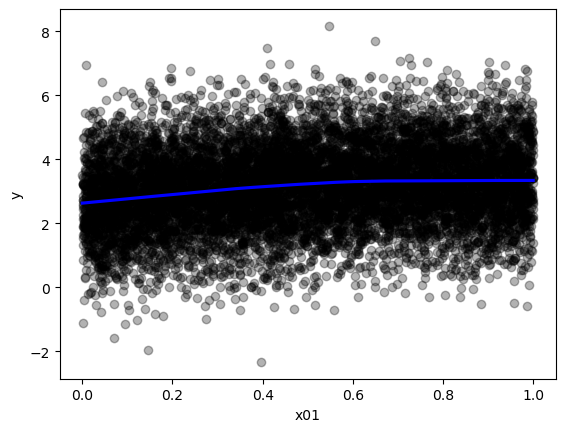

In [161]:
sns.regplot(df, x='x01', y='y', 
  lowess=True,
  scatter_kws={"color": "black", "alpha": 0.3}, 
  line_kws={"color": "blue"})

Just to illustrate the potential bias with non-linear confounders, we'll start by building a simple regression model that includes all `x` varaibles:


In [162]:
my_formula = 'y ~ x01 + x02 + x03 + x04 + x05 + x06 + x07 + x08 + x09 + x10 + T'
mod = smf.ols(formula=my_formula, data=df)
fit = mod.fit()
# Extract the treatment coefficient
ate_lr = round(fit.params['T'], 2)
print(f'The average treatment effect using Linear Regression is: {ate_lr}')

The average treatment effect using Linear Regression is: 0.86


### Linear DML

Let's now train a linear double machine learning model.

In Python, we use `LinearDML` from **EconML**. This function requires that we specify the algorithms for the two ML models:

-   `model_t`: the model for the treatment
-   `model_y`: the model for the outcome

Here, we'll use the lightweight implementation of gradient boosted trees from **lightgbm** for speed (note that you can use all the scikit-learn algorithms here as well). We need to use the classifier for the treatment as it is a binary outcome, and the regressor for the outcome (sales). Once loaded, we then instantiate the model:

In [163]:
from econml.dml import LinearDML
from lightgbm import LGBMRegressor, LGBMClassifier

dml = LinearDML(model_y=LGBMRegressor(verbose=-1), 
                model_t=LGBMClassifier(verbose=-1), 
                discrete_treatment=True)

Next extract the values into numpy arrays:

In [164]:
features = ['x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10']
X = df[features].to_numpy()
y = df['y'].to_numpy()
T = df['T'].to_numpy()

And now let's fit the model. The syntax here indicates to use all variables as confounders (`W=X`) and none of the variables to model the effect. This will result in a constant, homogenous effect, with no variation across observations.


In [165]:
dml.fit(y, T=T, X=None, W=X)

With that done, we can explore the model results. Here's the ATE. This should be much closer to the true values (0.75) than the simple linear model

In [166]:
dml.ate()

We can also access the individual models. For the treatment model (note that there will be more than one model from internal cross validation):

In [167]:
mod_t = dml.models_t[0][0]

And the outcome model:

In [168]:
mod_y = dml.models_y[0][0]

As these are regular Python models, we can extract and plot the feature importance:

<Axes: xlabel='importance', ylabel='feature'>

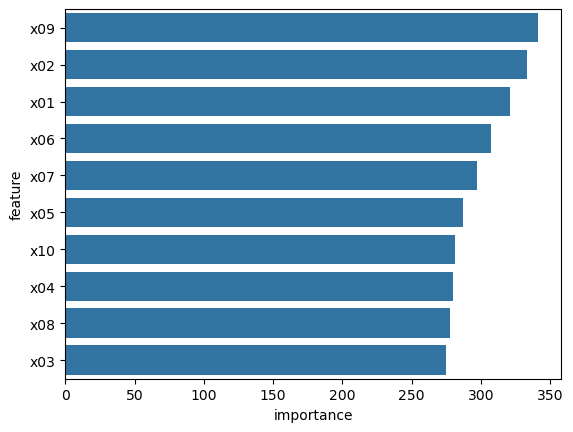

In [169]:
importances = mod_y.feature_importances_
indices = np.argsort(importances)[::-1]
vip_df = pd.DataFrame({'feature': df.columns[0:10][indices],
                   'importance': importances[indices]})
sns.barplot(vip_df, x = 'importance', y = 'feature')

Or partial dependencies. Here, for example, is the partial dependency of the treatment on `X01`:

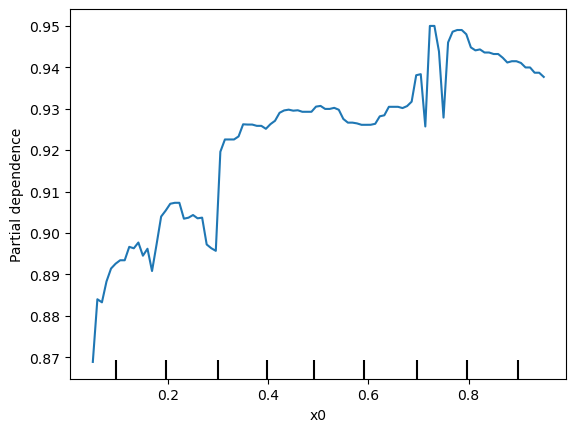

In [170]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(mod_t, X, [0])

And the partial dependency of the outcome on `X01`:

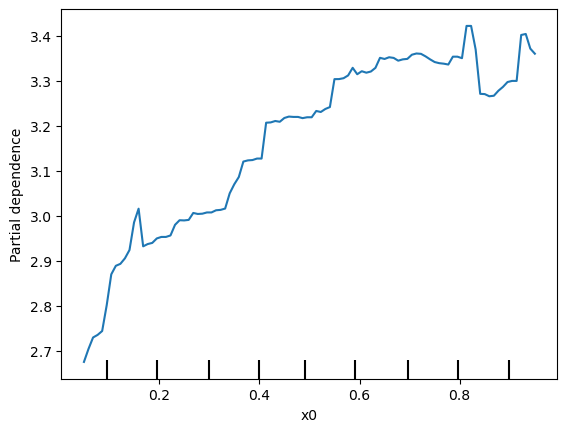

In [171]:
PartialDependenceDisplay.from_estimator(mod_y, X, [0])

### DML with heterogenous treatment

The previous model assumed that the effect (once debiased) is constant across all observations. We can adjust that by using the features to model variations in the treatment effect ($\tau$). This changes the final model in the DML series (the regression of residuals) to:

$$
\widetilde{Y} \sim \widetilde{T} + X
$$

To set this in the `LinearDML` model, we simply set `X=X`, to indicate that the features should be used to estimate variations in the treatment *as well* as in the confounding effects.

In [172]:
dml = LinearDML(model_y=LGBMRegressor(verbose=-1), 
                model_t=LGBMClassifier(verbose=-1), 
                discrete_treatment=True)
dml.fit(y, T=T, X=X, W=X)

Here's the new ATE (should still be relatively unbiased):

In [173]:
np.round(dml.ate(X=X), 2)


We'll illustrate the effect quickly here, by plotting the individual effects (CATE) against the values for the first variable (`X01`), which shows a small decline in effect at high values (note that this is just an effect of the randomness in the synthetic data, as no trend was added when the data was produced)

<Axes: xlabel='x01', ylabel='eff'>

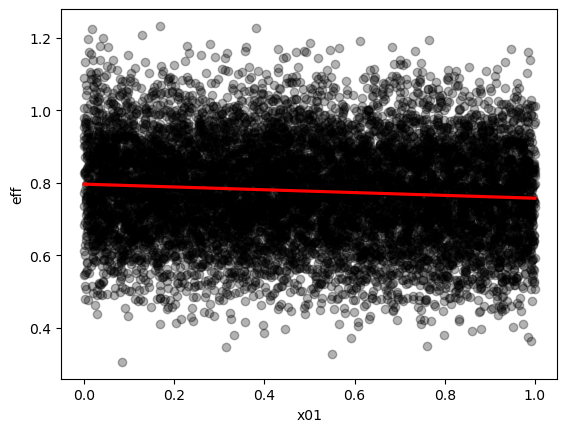

In [174]:
df['eff'] = dml.effect(X=X)
sns.regplot(df, x='x01', y='eff',
                 scatter_kws={"color": "black", "alpha": 0.3}, 
                 line_kws={"color": "red"})


Note that all the extra interpretation can still be applied to this model.


### Causal Forest DML

In the previous step, we went from a homogeneous treatment effect to a heterogeneous effect. As that model retains a linear estimate in the final stage, the only possible variation is linear and monotonic. For more complex CATE estimates, we can replace this final stage with a non-parametric estimator, for example, a causal forest.

We'll use another dataset here (*week11_4.csv*). This has a similar design to the previous set, with 10 features as potential confounders (`X01` to `X10`), one binary treatment (`T`) and an outcome (`y`). The main difference is that the treatment variable depends on the first confounder. Where `X01` is below zero, the treatment effect is zero, and then it scales linearly at $X_{01} > 0$

You can visualize the true effect as follows:

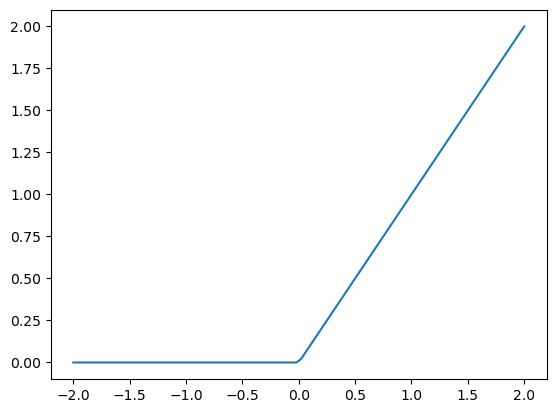

In [175]:
X0_test = np.linspace(-2, 2, 100)
effect_test = X0_test.copy()
effect_test[X0_test < 0] = 0

plt.plot(X0_test, effect_test)


Let's get the data

In [176]:
df = pd.read_csv("./data/week11_ex4.csv")
df.head()

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,y,T
0,-1.085631,0.997345,0.282978,-1.506295,-0.578600,1.651437,-2.426679,-0.428913,1.265936,-0.866740,1.558972,1
1,-0.678886,-0.094709,1.491390,-0.638902,-0.443982,-0.434351,2.205930,2.186786,1.004054,0.386186,0.257717,1
2,0.737369,1.490732,-0.935834,1.175829,-1.253881,-0.637752,0.907105,-1.428681,-0.140069,-0.861755,1.800572,0
3,-0.255619,-2.798589,-1.771533,-0.699877,0.927462,-0.173636,0.002846,0.688223,-0.879536,0.283627,-4.825400,0
4,-0.805367,-1.727669,-0.390900,0.573806,0.338589,-0.011830,2.392365,0.412912,0.978736,2.238143,-2.488931,0


And convert to numpy arrays:

In [177]:
features = ['x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10']
X = df[features].to_numpy()
y = df['y'].to_numpy()
T = df['T'].to_numpy()

Before estimating this with a causal forest, we'll use a linear DML model. We'll use `LinearDML` again to fit this. The main difference is that we'll allow the function to automatically choose the best algorithm between linear and forest approaches for the treatment and outcome model. We'll again set `X=X` to get the model to estimate heterogenous treatment effects.

In [178]:
dml = LinearDML(model_y='auto', 
                model_t='auto', 
                discrete_treatment=True)
dml.fit(y, T=T, X=X, W=X)

We can obtain the ATE as before with `dml.ate()`. 

In [179]:
ate_lr = np.round(dml.ate(X=X), 2)
print(f'The average treatment effect using Linear Regression is: {ate_lr}')

The average treatment effect using Linear Regression is: 0.33


In addition, we can extract the CATE or local treatment effect for each observation with `effect()`

<Axes: xlabel='cate', ylabel='Count'>

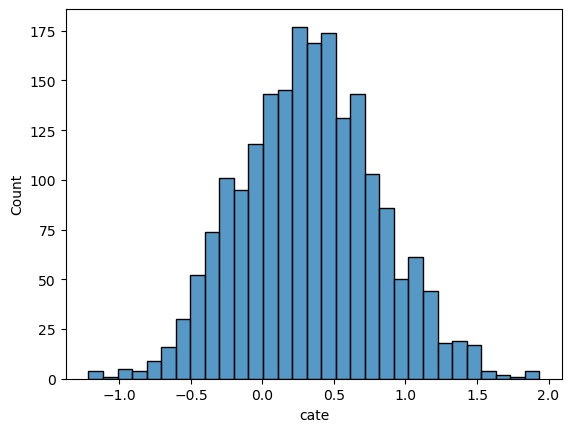

In [180]:
df['cate'] = dml.effect(X=X)
sns.histplot(df, x = 'cate')

Now let's plot the effect over a range of values of `X01` to see if it matches the true effect. We'll also obtain and plot confidence intervals around the local treatment effect (with `effect_interval`):

In [181]:
X_test = np.zeros((100, 10))
X_test[:, 0] = np.linspace(-2, 2, 100)

In [182]:
y_pred_dml = dml.effect(X_test)
lb, ub = dml.effect_interval(X_test, alpha=0.01)

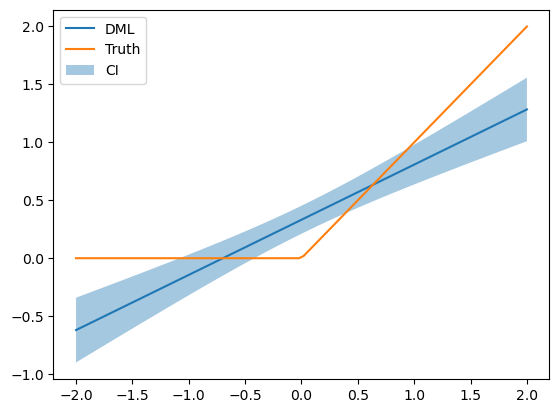

In [183]:
plt.plot(X_test[:,0], y_pred_dml, label="DML")
plt.plot(X0_test, effect_test, label="Truth")
plt.fill_between(X0_test, lb, ub, alpha=.4, label='CI')
plt.legend()
plt.show()


The `LinearDML` model does capture variation in the treatment, but only as a linear function. Now let's fit the causal forest. The **EconML** library contains a function (`CausalForestDML`) for double machine learning with a causal forest. The syntax is pretty much the same as the linear DML. We'll again use the automatic choice of first stage models. We'll estimate a larger number of trees in the forest to help stabilize the variance of the predictions.

In [184]:
from econml.dml import CausalForestDML
cfdml = CausalForestDML(model_t='auto',
                        model_y='auto',
                        discrete_treatment=True,
                        n_estimators=500)
cfdml.fit(y, T, X=X, W=X)

And compare the modeled effect. Now you should see that the causal forest is able to estimate a non-linear change in treatment effects that maps well to the true, expected function

In [185]:
y_pred_dml = cfdml.effect(X_test)
lb, ub = cfdml.effect_interval(X_test, alpha=0.01)

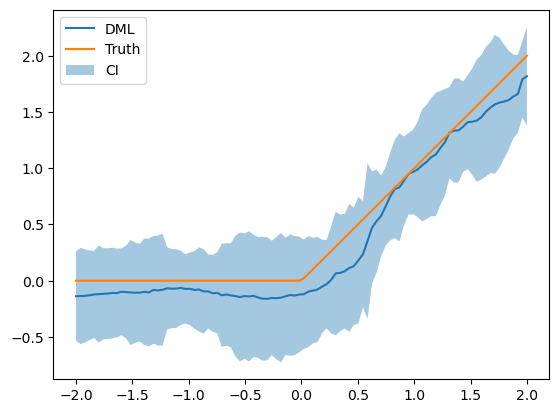

In [186]:
plt.plot(X0_test, y_pred_dml, label="DML")
plt.plot(X0_test, effect_test, label="Truth")
plt.fill_between(X0_test, lb, ub, alpha=.4, label='CI')
plt.legend()
plt.show()